### Information visualization in PyTorch

In [1]:
import torch
from torch import nn as nn
gpu    = torch.cuda.is_available()
device = torch.device(0) if gpu else torch.device('cpu')
import math
model_name = 'FMNISTCNN'

To load a model you need its class (architecture), because you need to create a model with random initialization and then load its state_dict with the weights from the pth file. 


In [2]:
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )
  
class FMNISTNet(nn.Module):

    def __init__(self, num_classes):
        super(FMNISTNet, self).__init__()
        
        #define the first conv_block
        self.conv1 = conv_block(1,16,1)
        
        #defining the second conv_block
        
        self.conv2 = conv_block(16,64,2) 
        
        #defining classifier
        self.classifier = nn.Sequential(
            #defining linear layer
            nn.Linear(in_features=int((28*28*(16+64))/(2*2)), out_features=512, bias=True),
            #defining activation layer
            nn.ReLU(),
            # defining a dropout layer
            nn.Dropout(0.2),
            #defining linear layer as decision layer
            nn.Linear(512, num_classes) #Note that you do not need nn.Softmax in torch
        )

        #initialize weights
        self._initialize_weights()

    def forward(self, x):
        #extracts features
        x1      = self.conv1(x)
        x2      = self.conv2(x1)
        #resizes x1 to have the same size of x2
        x1      = torch.nn.functional.interpolate(x1, scale_factor=(0.5, 0.5), mode='nearest',
                                                  recompute_scale_factor=True)
        #performs skip connection 
        x       = torch.cat((x1, x2), dim=1)
    
        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y
  
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels

                #initialize layer weights with random values generated from a normal
                #distri # FMNISTNet1 or FMNISTNet2bution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()                       

In [3]:
num_classes = 10
# create the model with random weight initialization
model = FMNISTNet(num_classes) 
# load its dictionary with weights and bias    
state_dict  = torch.load('FMNistCNN.pth') 
for key, value in state_dict.items():
    if key.split(".")[1]=="weight":
        print("layer name: {}, weights: {}".format(key,value))
    else:
        print("layer name: {}, bias: {}".format(key,value))
# set weights and bias of the NN, and register it to the selected device    
model.load_state_dict(state_dict) 
model.to(device) 

layer name: conv1.0.weight, bias: tensor([[[[-2.1022e-01, -7.9148e-01, -2.5628e-01],
          [ 5.1559e-01, -1.4715e-01,  4.9305e-01],
          [ 5.5383e-01, -2.4267e-01,  1.5470e-01]]],


        [[[ 7.0337e-01, -1.8408e-01,  1.8114e-01],
          [-3.6625e-01,  4.7328e-01,  4.2460e-02],
          [-8.9976e-01, -8.5467e-01, -4.6379e-01]]],


        [[[-2.4507e-01, -4.5146e-01, -2.6123e-01],
          [ 3.7534e-01,  5.9585e-01,  6.9236e-01],
          [ 3.7484e-01, -8.8154e-02, -6.8738e-02]]],


        [[[ 3.3419e-02,  2.6093e-02,  4.8214e-01],
          [-1.0785e-01,  3.6355e-01,  1.0386e-01],
          [ 4.0156e-01, -1.0134e+00, -3.5307e-01]]],


        [[[ 4.1551e-01,  5.2366e-01, -5.5525e-01],
          [-4.3153e-01,  6.4249e-01, -3.0037e-01],
          [-5.4588e-01, -7.7921e-02,  3.9342e-01]]],


        [[[-2.1011e-01,  1.8497e-01, -2.7590e-01],
          [ 4.9891e-01, -1.0894e-01, -1.8580e-01],
          [ 5.3794e-01,  7.2170e-01,  3.1765e-01]]],


        [[[-1.4028e-01, 

FMNISTNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=1, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=15680, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [4]:
# Just for curiosity: how to access operations in each block. This allows to run layer.forward(x)
# to execute an operation
for layer_name, layer in model.conv2.named_children():
    print(layer_name, layer)

0 Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
2 ReLU()
3 MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)


In [5]:
from collections import OrderedDict

In [6]:
#function to get the output of each layer/block in FMINISTNet
def get_each_output(model, x):
    #empty dict
    output_by_layer = OrderedDict()
  
    #get the input
    output_by_layer['input'] = x.clone().detach().cpu().data.numpy()

    #for the first block, get its output and save it   
    x1 = model.conv1(x)
    output_by_layer["featextract-conv1"] = x1.clone().detach().cpu().numpy()

    #for the second block, get its output and save it
    x2 = model.conv2(x1)
    output_by_layer["featextract-conv2"] = x2.clone().detach().cpu().numpy()    
    
    #resizes and concatenate x1 and x2, saving the output
    x1 = torch.nn.functional.interpolate(x1, scale_factor=(0.5, 0.5), mode='nearest',
                                         recompute_scale_factor=True) 
    x  = torch.cat((x1, x2), dim=1)
    output_by_layer["featextract-concat"] = x.clone().detach().cpu().numpy()    
    
    #transform features to a 2D tensor: you do not need to show this one
    x = x.flatten(start_dim=1)
    
    #for each layer of the classifier (note that you could have done that for model.conv1 and model.conv2 as well)
    for layer_name, layer in model.classifier.named_children():
        #do forward through the layer   
        x = layer.forward(x)
        #save the output
        output_by_layer["classifier-"+layer_name] = x.clone().detach().cpu().numpy()
  
    #return output by layer
    return output_by_layer

In [7]:
#get the outputs, and labels
def get_ouputs(model, dataload, device, model_name):
    outputs_by_layer = None
    all_labels = None

    #get a batch from the dataload
    for inputs, labels in dataload:
        #move inputs to the correct device
        inputs = inputs.to(device)
        labels = labels.clone().detach().cpu().numpy()

        #get the activations for visualization
        outputs = get_each_output(model, inputs)
            
        #save the outputs
        if outputs_by_layer is None:
            outputs_by_layer = outputs
            all_labels       = labels
        else:
            for layer in outputs:
                outputs_by_layer[layer] = np.concatenate((outputs_by_layer[layer], outputs[layer]), axis=0)
            all_labels = np.concatenate((all_labels, labels))   

    return outputs_by_layer, all_labels

In [8]:
#maps from high dimension to 2D
def projection(outputs_by_layer, reducer):
    projection_by_layer = OrderedDict()

    for layer in outputs_by_layer:
        #get the output of layer
        output = outputs_by_layer[layer]
        output = output.reshape(output.shape[0], -1)
        #map to 2D
        embedded = reducer.fit_transform(output)
        #save projection
        projection_by_layer[layer] = embedded
  
    return projection_by_layer

In [9]:
#create a dataset randomly for visualization
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()]) 
# Since train=False, you are loading the true test set of FMNIST
data      = datasets.FashionMNIST(root="./images", train=False, download=True, transform=transform)
projset, dummyset = random_split(data, [1000, 9000]) # select only 1000 images for visualization
projload  = DataLoader(projset, batch_size=64)

In [10]:
#import umap to calculate projection
import umap.umap_ as umap

#import tsne to calculate projection
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [11]:
#plot the projection of the output of each layer
def create_visualization(projection_by_layer, all_labels):
  
    for layer in projection_by_layer:
        embedded = projection_by_layer[layer]
  
        fig = plt.figure(figsize=(8, 8))
        plt.scatter(embedded[:, 0], embedded[:, 1], c=all_labels, cmap=plt.get_cmap('tab10'))
        plt.axis("off")
        plt.title(layer)
        plt.colorbar()
        plt.show()
        plt.close(fig)

In [12]:
#reducer = umap.UMAP()
reducer = TSNE(perplexity=30)

In [13]:
outputs_by_layer, all_labels = get_ouputs(model, projload, device, model_name)
projection_by_layer = projection(outputs_by_layer, reducer)

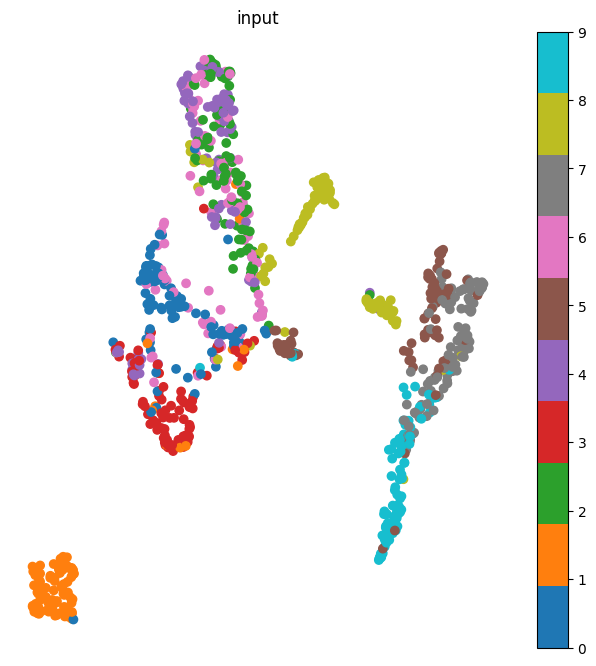

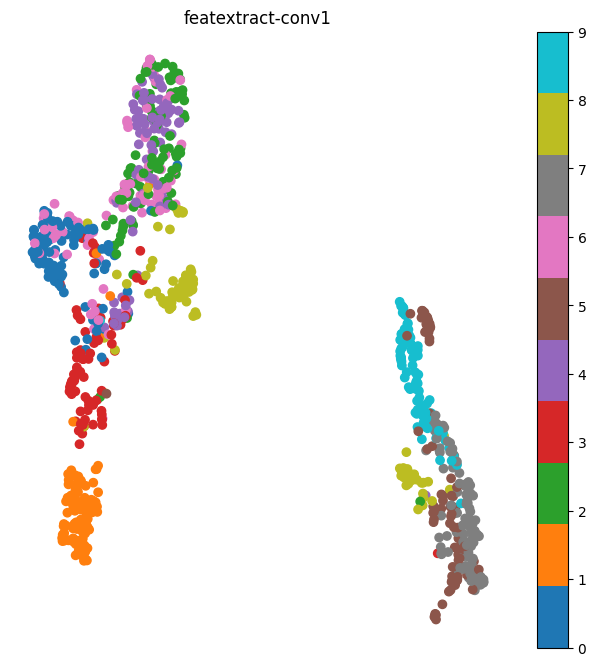

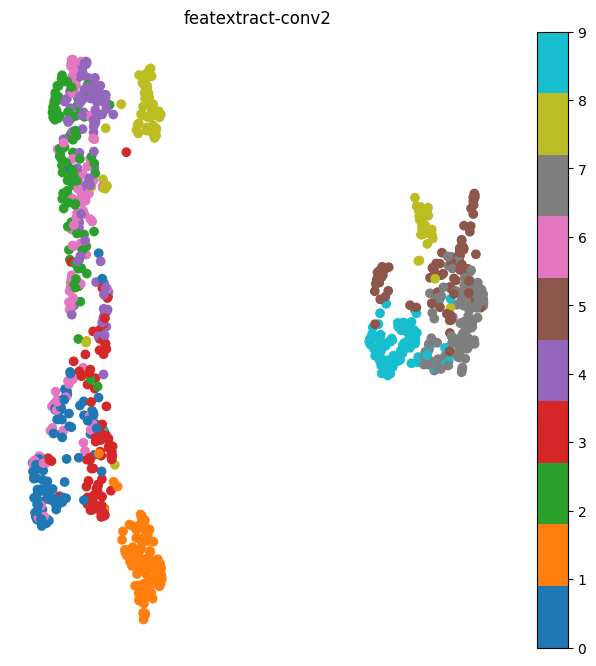

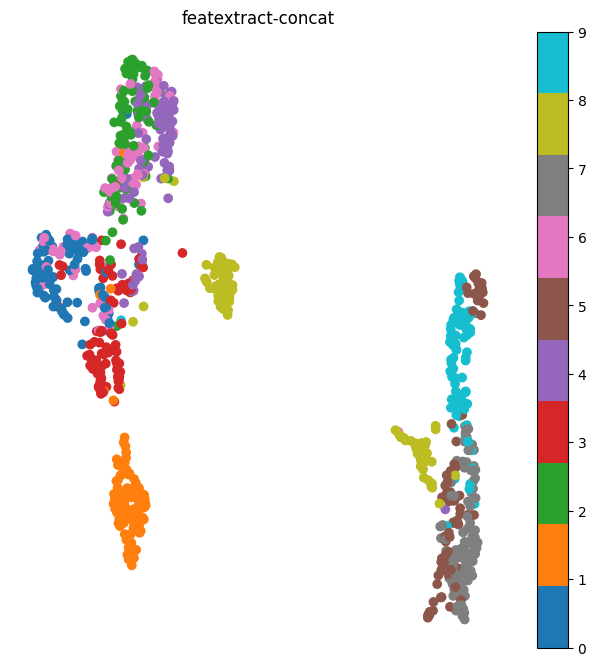

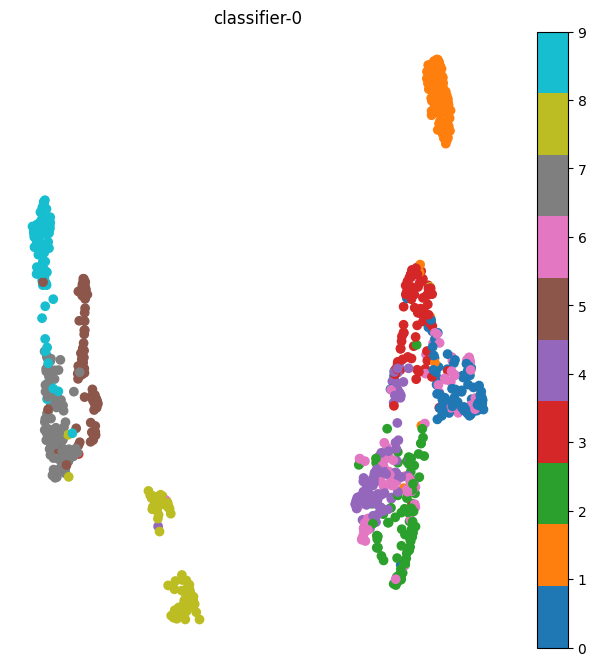

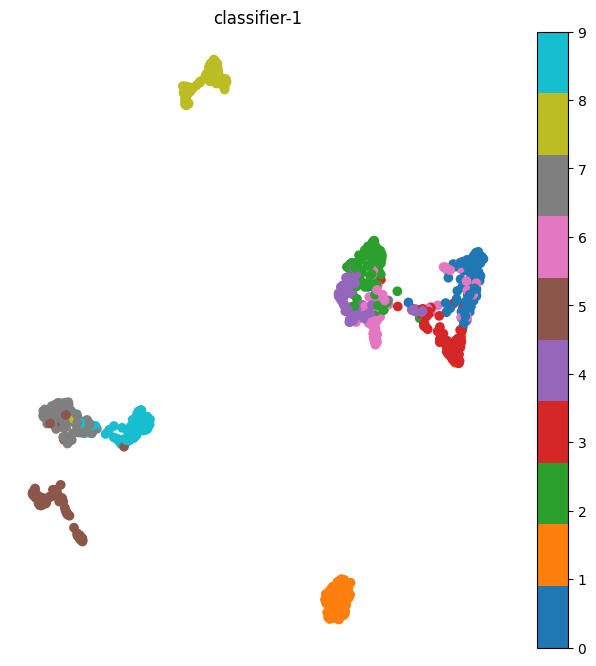

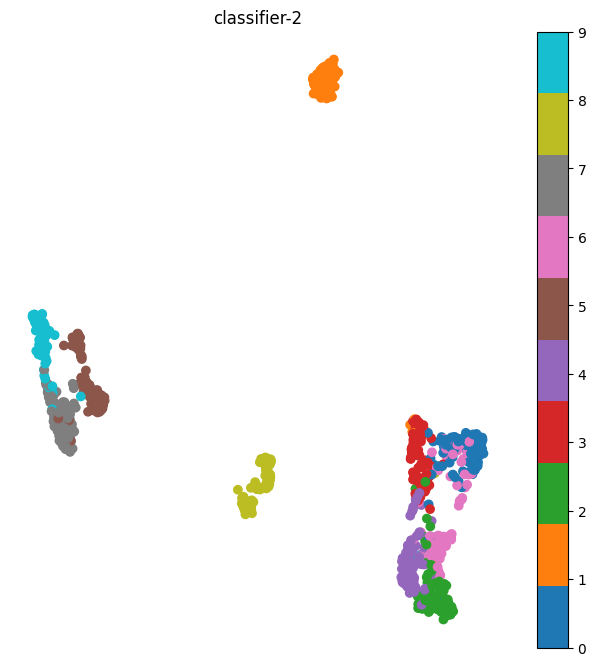

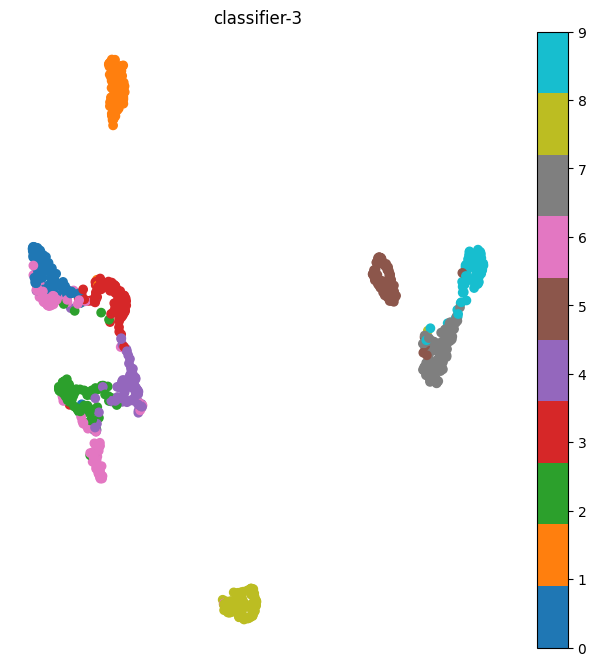

In [14]:
create_visualization(projection_by_layer, all_labels)

### You may observe improved class separation along convolutional layers in deeper networks, but such effect becomes more evident along linear (dense) layers. You can revisit visualization once you improve your model. 

### Visualize attention (CAMs) to explain a decision

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from IPython.display import Image, display

true label:  Trouser
predicted label:  Trouser
torch.Size([1, 80, 14, 14])


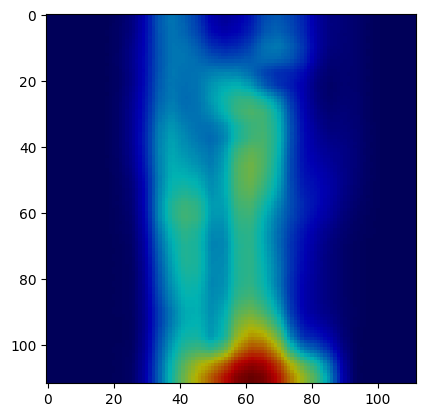

In [16]:
def get_activations(model, x, device):
    # move input tensor x to the selected device
    x = x.to(device)
    # get activations after feature extraction
    x1 = model.conv1(x)
    x2 = model.conv2(x1)
    x1 = torch.nn.functional.interpolate(x1, scale_factor=(0.5, 0.5), mode='nearest',
                                         recompute_scale_factor=True) 
    x  = torch.cat((x1, x2), dim=1) 

    return x

def get_output_of_the_model(model, x, device):
    # put the model in the evaluation mode
    model.eval() 
    # move input tensor x to the selected device
    x = x.to(device) 
    # execute the model with gradients
    output = model(x)
    return(output)

def get_heatmap(model, x, device, model_name, labels_map):
    # add one dimension (dim=0 must be the number of images)
    xin = x.unsqueeze(0)
    
    # get the output of the feature extractor 
    activ  = get_activations(model, xin, device)
        
    # get the predictions at the output of the decision layer
    logits = get_output_of_the_model(model, xin, device)
    
    # get the most confident prediction
    pred   = logits.max(-1)[-1] 
    print("predicted label: ", labels_map[pred.cpu().detach().numpy()[0]])
    
    # compute gradients with respect to the most confident prediction
    model.zero_grad() 
    logits[0,pred].backward(retain_graph=True) 
    
    
    print(activ.shape)
    # only conv2D generates gradients in the feature extractor: extracts them.  
    for layer_name, layer in model.conv1.named_children():
        if layer_name == '0':
            grad1 = layer.weight.grad
            nchannels1 = grad1.shape[0]
            # compute the weighted mean of the activations across channels using the mean value of the gradient 
            # of each filter parameter as weight. 
            for i in range(16):
                activ[:,i,:,:] *= grad1[i].mean()
    for layer_name, layer in model.conv2.named_children():
        if layer_name == '0':
            grad2 = layer.weight.grad
            nchannels2 = grad2.shape[0]     
            for i in range(64):
                activ[:,i+16,:,:] *= grad2[i].mean()
                
    heatmap = torch.mean(activ, dim=1)[0].cpu().detach()

    # convert to numpy, normalize, and resize to the input size
    heatmap = heatmap.squeeze(0).numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
    return(heatmap)

def display_image_with_heatmap(img, heatmap, scale):
    heatmap = np.uint8(255.0*heatmap)
    width   = int(heatmap.shape[1]*scale)
    height  = int(heatmap.shape[0]*scale)
    heatmap = cv2.resize(heatmap, (width, height))
    img     = cv2.resize(img, (width, height))
    heatmap = cv2.applyColorMap(255-heatmap, cv2.COLORMAP_JET)
    heatmap = np.uint8(heatmap)
    heatmap = np.uint8(heatmap*0.7 + img*0.3)
    plt.imshow(heatmap)
    plt.show()

# get the first image tensor
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

x          = projset[20][0]
true_label = projset[20][1]
print("true label: ", labels_map[true_label])
heatmap = get_heatmap(model, x, device, model_name, labels_map)
x       = x.permute(1,2,0).numpy()
if (x.shape[2]==1): # convert it to three channels
    x = x.squeeze(2)
    x = np.stack((x,)*3,axis=-1)  
display_image_with_heatmap(x, heatmap, 4)

#### Exercise 1: Adapt this notebook for CorelCNN.pth.

#### Exercise 2: Add visualization of all activation channels at the output of a given layer for CorelCNN.pth. Einops (https://einops.rocks/) facilitates the manipulation of the multidimensional image (tensor) to arrange the channels in a single 2D image. 

#### Exercise 3: Similarly to the activation projection, add projection of the kernels at the output of all layers for CorelCNN.pth.